In [1]:
import sys
import os

# Add the src directory to the Python path
src_path = os.path.join(os.getcwd(), 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

In [2]:
import numpy as np
import pandas as pd
from itertools import product
from sklearn.model_selection import train_test_split
from src.optimizers import *
from src.activation_functions import * 
from src.utils import *
from src.model_regularization import *
from src.layer import *
np.random.seed(0)


#### Data pre-processing for MONK Datasets 

In [3]:
########################################################
### Don't forget to change the path to the data file ###
########################################################

df = pd.read_csv("../ML_project/data/Monk_2/monks-2.train", names=[0,1,2,3,4,5,6,"index"], delimiter= " ")
# df = pd.read_csv("../ML_project/data/Monk_2/monks-2.train",
#                  names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
df.set_index("index", inplace=True)
y = df.iloc[:, 0]  # First column as target
X = df.iloc[:, 1:]  # All other columns as features
for i in range(1, X.shape[1]):
    X.iloc[:, i] = (X.iloc[:, i] - np.mean(X.iloc[:, i])) / \
        np.std(X.iloc[:, i])
X.head()

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_33708\2688392090.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_4     -1.233337
data_7     -1.233337
data_9     -1.233337
data_10    -1.233337
data_11    -1.233337
              ...   
data_421    1.293135
data_422    1.293135
data_425    1.293135
data_427    1.293135
data_432    1.293135
Name: 2, Length: 169, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X.iloc[:, i] = (X.iloc[:, i] - np.mean(X.iloc[:, i])) / \
C:\Users\Mostafa\AppData\Local\Temp\ipykernel_33708\2688392090.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_4     -1.017912
data_7     -1.017912
data_9     -1.017912
data_10    -1.017912
data_11    -1.017912
              ...   
data_421    0.982403
data_422    0.982403
data_425    0.982403
data_42

,1,2,3,4,5,6
index,,,,,,
data_4,1,-1.233337,-1.017912,-1.264063,-0.432844,0.994100
data_7,1,-1.233337,-1.017912,-1.264063,1.395921,-1.005935
data_9,1,-1.233337,-1.017912,-0.050275,-1.347226,-1.005935
data_10,1,-1.233337,-1.017912,-0.050275,-1.347226,0.994100
data_11,1,-1.233337,-1.017912,-0.050275,-0.432844,-1.005935


In [4]:
########################################################
### Don't forget to change the path to the data file ###
########################################################

test_data = pd.read_csv("../ML_project/data/Monk_2/monks-2.test",
names=[0, 1, 2, 3, 4, 5, 6, "index"], delimiter=" ")
test_data.set_index("index", inplace=True)
# test_data.head()
y_test = test_data.iloc[:, 0]
X_test = test_data.iloc[:, 1:]
for i in range(1, X_test.shape[1]):
    X_test.iloc[:, i] = (X_test.iloc[:, i] - np.mean(X_test.iloc[:, i])) / np.std(X_test.iloc[:, i])

C:\Users\Mostafa\AppData\Local\Temp\ipykernel_33708\3608836368.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_1     -1.224745
data_2     -1.224745
data_3     -1.224745
data_4     -1.224745
data_5     -1.224745
              ...   
data_428    1.224745
data_429    1.224745
data_430    1.224745
data_431    1.224745
data_432    1.224745
Name: 2, Length: 432, dtype: float64' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_test.iloc[:, i] = (X_test.iloc[:, i] - np.mean(X_test.iloc[:, i])) / np.std(X_test.iloc[:, i])
C:\Users\Mostafa\AppData\Local\Temp\ipykernel_33708\3608836368.py:12: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'index
data_1     -1.0
data_2     -1.0
data_3     -1.0
data_4     -1.0
data_5     -1.0
           ... 
data_428    1.0
data_429    1.0
data_430    1.0
data_431    1

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Print the shape of the resulting datasets
print("Training Features Shape:", X_train.shape)
print("Validation Features Shape:", X_val.shape)
print("Training Target Shape:", y_train.shape)
print("Validation Target Shape:", y_val.shape)

Training Features Shape: (135, 6)
Validation Features Shape: (34, 6)
Training Target Shape: (135,)
Validation Target Shape: (34,)


In [8]:
class Loss:
    def calculate(self, output, y):
        sample_losses = self.forward(output, y)
        data_loss = np.mean(sample_losses)
        return data_loss

class Loss_CategoricalCrossentropy(Loss):
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1-1e-7)

        if len(y_true.shape) == 1:
            correct_confidence = y_pred_clipped[range(samples), y_true]

        elif len(y_true.shape) == 2:
            correct_confidence = np.sum(y_pred_clipped * y_true, axis=1) 

        negative_log_likelihoods = np.log(correct_confidence)
        return negative_log_likelihoods

    def backward(self, dvalues, y_true):

        # Number of samples
        samples = len(dvalues)
        # Number of labels in every sample
        # We'll use the first sample to count them
        labels = len(dvalues[0])

        # If labels are sparse, turn them into one-hot vector
        if len(y_true.shape) == 1:
            y_true = np.eye(labels)[y_true]

        # Calculate gradient
        self.dinputs = -y_true / dvalues
        # Normalize gradient
        self.dinputs = self.dinputs / samples


class Activation_Softmax_Loss_CategoricalCrossentropy():

    def __init__(self):
        self.activation = Activation_Softmax()
        self.loss = Loss_CategoricalCrossentropy()


    def forward(self, inputs, y_true):
        # Output layer's activation function
        self.activation.forward(inputs)

        # Set the output
        self.output = self.activation.output

        return self.loss.calculate(self.output, y_true)

    def backward(self, dvalues, y_true):
        samples = len(dvalues)

        if len(y_true.shape) == 2:
            y_true = np.argmax(y_true, axis=1)

        self.dinputs = dvalues.copy()

        self.dinputs[range(samples), y_true] -= 1

        self.dinputs = self.dinputs / samples

class MSE:
    def __init__(self):
        self.dinputs = 0
        self.loss = 0
        self.output = 0
        
        
    def forward(self, y_pred, y_true):
        self.output = np.mean((y_pred - y_true)**2)
        return self.output
    
    def backward(self, dvalues, y_true):
        samples = len(dvalues)
        outputs = len(dvalues[0])
        
        self.dinputs = -2 * (y_true - dvalues) / outputs
        self.dinputs = self.dinputs / samples

In [9]:
class NN:
    def __init__(self, l1, l2, input_size, hidden_sizes, output_size, 
                 hidden_activations=None, dropout_rates=None):
        self.layers = []
        prev_size = input_size
        
        # Default to ReLU if no activations specified
        if hidden_activations is None:
            hidden_activations = [Activation_ReLU() for _ in hidden_sizes]
        
        # Default to no dropout
        if dropout_rates is None:
            dropout_rates = [0.0] * len(hidden_sizes)
            
        # Create hidden layers
        for size, activation, rate in zip(hidden_sizes, hidden_activations, dropout_rates):
            self.layers.append(Layer_Dense(prev_size, size,l1=l1, l2=l2))
            self.layers.append(activation())
            if rate > 0:
                self.layers.append(Dropout(rate))
            prev_size = size
        
        # Output layer (no activation)
        self.layers.append(Layer_Dense(prev_size, output_size))
        
    def forward(self, inputs, training=True):
        for layer in self.layers:
            if isinstance(layer, Dropout):
                layer.forward(inputs, training)
            else:
                layer.forward(inputs)
            inputs = layer.output
        self.output = inputs

In [10]:
def train_and_evaluate(learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation):
    # Initialize components
    model = NN(
        l1=l1,
        l2=l2,
        input_size=6,
        hidden_sizes=[10],
        output_size=2,
        hidden_activations=[activation],
        dropout_rates=[dropout_rate]
    )
    
    loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
    optimizer = Optimizer_Adam(learning_rate=learning_rate)

    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(n_epochs):
        batch_losses = []
        batch_accuracies = []
        
        for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
            # Forward pass through model
            model.forward(X_batch, training=True)
            
            # Calculate loss through separate loss activation
            loss = loss_activation.forward(model.output, y_batch)
            # print(y_batch.shape)
            # Calculate accuracy
            predictions = np.argmax(loss_activation.output, axis=1)
            accuracy = np.mean(predictions == y_batch)
            
            # Backward pass
            loss_activation.backward(loss_activation.output, y_batch)
            dvalues = loss_activation.dinputs
            
            # Propagate gradients through model layers in reverse
            for layer in reversed(model.layers):
                layer.backward(dvalues)
                dvalues = layer.dinputs
                
                # # Apply L1/L2 regularization to dense layers
                # if isinstance(layer, Layer_Dense):
                #     if layer.l1 > 0:
                #         layer.dweights += layer.l1 * np.sign(layer.weights)
                #     if layer.l2 > 0:
                #         layer.dweights += 2 * layer.l2 * layer.weights
            
            # Update parameters
            optimizer.pre_update_params()
            for layer in model.layers:
                if isinstance(layer, Layer_Dense):
                    optimizer.update_params(layer)
            optimizer.post_update_params()
            
            batch_losses.append(loss)
            batch_accuracies.append(accuracy)

        # Epoch metrics
        epoch_loss = np.mean(batch_losses)
        epoch_accuracy = np.mean(batch_accuracies)
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_accuracy)

        # Validation pass
        model.forward(X_val, training=False)
        val_loss = loss_activation.forward(model.output, y_val)
        val_predictions = np.argmax(loss_activation.output, axis=1)
        val_accuracy = np.mean(val_predictions == y_val)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

    return val_accuracies[-1]

In [11]:
hyperparameter_grid = {
    'learning_rate': [0.001],
    'l1': [0.0, 1e-5],
    'l2': [0.0, 1e-4],
    'dropout_rate': [0.1, 0.5],
    'batch_size': [4],
    'n_epochs': [100, 200],
    'activation': [Activation_Sigmoid, Activation_Leaky_ReLU]
}

In [12]:
# Initialize variables to store the best hyperparameters and performance
best_hyperparams = None
best_performance = -np.inf  # Assuming we are maximizing validation accuracy

# Iterate over all combinations of hyperparameters
for params in product(*hyperparameter_grid.values()):
    # Unpack the hyperparameters
    learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation = params
    # Train and evaluate the model
    val_accuracy = train_and_evaluate(learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation)
    
    # Update the best hyperparameters if the current model is better
    if val_accuracy > best_performance:
        best_performance = val_accuracy
        best_hyperparams = {
            'learning_rate': learning_rate,
            'l1': l1,
            'l2': l2,
            'dropout_rate': dropout_rate,
            'batch_size': batch_size,
            'n_epochs': n_epochs,
            'activation': activation
        }

# Print the best hyperparameters and performance
print("Best Hyperparameters:", best_hyperparams)
print("Best Validation Accuracy:", best_performance)

Best Hyperparameters: {'learning_rate': 0.001, 'l1': 0.0, 'l2': 0.0, 'dropout_rate': 0.1, 'batch_size': 4, 'n_epochs': 100, 'activation': <class 'src.activation_functions.Activation_Leaky_ReLU'>}
Best Validation Accuracy: 0.7352941176470589


In [13]:
# final_model_performance = train_and_evaluate(**best_hyperparams)
# print("Final Model Performance:", final_model_performance)

In [28]:
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation = best_hyperparams.values()
learning_rate, l1, l2, dropout_rate, batch_size, n_epochs, activation

(0.001, 0.0, 0.0, 0.1, 4, 100, src.activation_functions.Activation_Leaky_ReLU)

In [29]:
model = NN(
    l1=l1,
    l2=l2,
    input_size=6,
    hidden_sizes=[10],
    output_size=2,
    hidden_activations=[activation],
    dropout_rates=[dropout_rate]
)

In [30]:
n_epochs = n_epochs

epoch: 0, train_acc: 0.669, train_loss: -0.677, val_acc: 0.441, val_loss: -0.700, learning_rate: 0.001
100 100


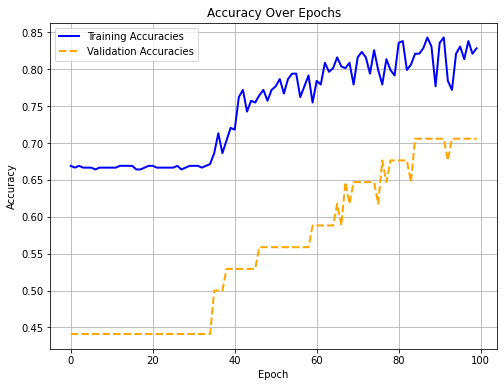

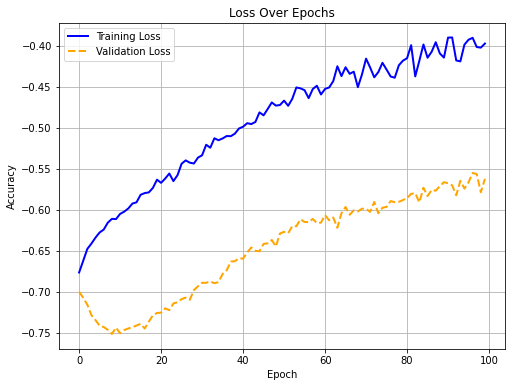

In [31]:
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

# early_stopping = EarlyStopping(
#     patience=20,
#     min_delta_loss=0.0001,
#     min_delta_accuracy=0.0001,
#     restore_best_weights=True
# )
loss_activation = Activation_Softmax_Loss_CategoricalCrossentropy()
optimizer = Optimizer_Adam(learning_rate=learning_rate)

# Training loop
for epoch in range(n_epochs):
    batch_losses = []
    batch_accuracies = []
    
    # Mini-batch training
    for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
    # Forward pass through model
        model.forward(X_batch, training=True)
        
        # Calculate loss through separate loss activation
        loss = loss_activation.forward(model.output, y_batch)
        # print(y_batch.shape)
        # Calculate accuracy
        predictions = np.argmax(loss_activation.output, axis=1)
        accuracy = np.mean(predictions == y_batch)
        
        # Backward pass
        loss_activation.backward(loss_activation.output, y_batch)
        dvalues = loss_activation.dinputs
        
        # Propagate gradients through model layers in reverse
        for layer in reversed(model.layers):
            layer.backward(dvalues)
            dvalues = layer.dinputs
            
            # # Apply L1/L2 regularization to dense layers
            # if isinstance(layer, Layer_Dense):
            #     if layer.l1 > 0:
            #         layer.dweights += layer.l1 * np.sign(layer.weights)
            #     if layer.l2 > 0:
            #         layer.dweights += 2 * layer.l2 * layer.weights
        
        # Update parameters
        optimizer.pre_update_params()
        for layer in model.layers:
            if isinstance(layer, Layer_Dense):
                optimizer.update_params(layer)
        optimizer.post_update_params()
            
        batch_losses.append(loss)
        batch_accuracies.append(accuracy)
    
    epoch_loss = np.mean(batch_losses)
    epoch_accuracy = np.mean(batch_accuracies)
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Validation pass
    model.forward(X_val, training=False)
    val_loss = loss_activation.forward(model.output, y_val)
    val_predictions = np.argmax(loss_activation.output, axis=1)
    val_accuracy = np.mean(val_predictions == y_val)
    val_losses.append(val_loss)
    val_accuracies.append(val_accuracy)
    # Calculate validation accuracy
    val_predictions = np.argmax(loss_activation.output, axis=1)
    if len(y_val.shape) == 2:
        y_val_true = np.argmax(y_val, axis=1)
    else:
        y_val_true = y_val
    val_accuracy = np.mean(val_predictions == y_val_true)
    
    
    # early_stopping.on_epoch_end(
    #     current_loss=val_loss,
    #     current_accuracy=val_accuracy,
    #     model=[dense1, dense2], 
    #     epoch=epoch
    # )
    # if early_stopping.stop_training:
    #     print(f"Early stopping at epoch {epoch}")
    #     break
    
    # Print progress
    if not epoch % 100:
        print(f"epoch: {epoch}, "
              f"train_acc: {epoch_accuracy:.3f}, train_loss: {epoch_loss:.3f}, "
              f"val_acc: {val_accuracy:.3f}, val_loss: {val_loss:.3f}, "
              f"learning_rate: {optimizer.current_learning_rate}")
print(len(val_accuracies), len(train_accuracies))
plot_accuracies(train_accuracies, val_accuracies, label1="Training Accuracies", label2="Validation Accuracies", title="Accuracy Over Epochs")
plot_accuracies(train_losses, val_losses, label1="Training Loss", label2="Validation Loss", title="Loss Over Epochs")

In [32]:
model.forward(X_test, training=False)
# Compute softmax probabilities for the test output
print(X_test.shape, y_test.shape)
loss_activation.forward(model.output, y_test) 
# Calculate accuracy for the test set
predictions = np.argmax(loss_activation.output, axis=1)
if len(y_test.shape) == 2:
    y_true = np.argmax(y_test, axis=1) 
else:
    print("we go here")
    y_true = y_test

# Compute test accuracy
test_accuracy = np.mean(predictions == y_true)
print(f"Test Accuracy: {test_accuracy:.4f}")

(432, 6) (432,)
we go here
Test Accuracy: 0.7639


In [20]:
# n_epochs = 350
# batch_size = 1


# train_losses = []
# train_accuracies = []
# val_losses = []
# val_accuracies = []

# # early_stopping = EarlyStopping(
# #     patience=20,
# #     min_delta_loss=0.0001,
# #     min_delta_accuracy=0.0001,
# #     restore_best_weights=True
# # )

# # Training loop
# for epoch in range(n_epochs):
#     batch_losses = []
#     batch_accuracies = []
    
#     # Mini-batch training
#     for X_batch, y_batch in create_batches(X_train, y_train, batch_size):
#         # Forward pass
#         dense1.forward(X_batch)
#         activation4.forward(dense1.output)
#         dense2.forward(activation4.output)
#         loss = loss_activation.forward(dense2.output, y_batch)
        
#         # Calculate accuracy for this batch
#         predictions = np.argmax(loss_activation.output, axis=1)
#         if len(y_batch.shape) == 2:
#             y_true = np.argmax(y_batch, axis=1)
#         else:
#             y_true = y_batch
#         accuracy = np.mean(predictions == y_true)
        
#         # Backward pass
#         loss_activation.backward(loss_activation.output, y_batch)
#         dense2.backward(loss_activation.dinputs)
#         activation4.backward(dense2.dinputs)
#         dense1.backward(activation4.dinputs)
        
#         # Update weights and biases
#         optimizer.pre_update_params()
#         optimizer.update_params(dense1)
#         optimizer.update_params(dense2)
#         optimizer.post_update_params()
        
#         batch_losses.append(loss)
#         batch_accuracies.append(accuracy)
    
#     # Calculate epoch-level training metrics
#     epoch_loss = np.mean(batch_losses)
#     epoch_accuracy = np.mean(batch_accuracies)
#     train_losses.append(epoch_loss)
#     train_accuracies.append(epoch_accuracy)

#     # Validation pass (entire validation dataset)
#     dense1.forward(X_val)
#     activation4.forward(dense1.output)
#     dense2.forward(activation4.output)
#     val_loss = loss_activation.forward(dense2.output, y_val)
    
#     # Calculate validation accuracy
#     val_predictions = np.argmax(loss_activation.output, axis=1)
#     if len(y_val.shape) == 2:
#         y_val_true = np.argmax(y_val, axis=1)
#     else:
#         y_val_true = y_val
#     val_accuracy = np.mean(val_predictions == y_val_true)
    
#     # Append validation metrics
#     val_losses.append(val_loss)
#     val_accuracies.append(val_accuracy)
    
#     # early_stopping.on_epoch_end(
#     #     current_loss=val_loss,
#     #     current_accuracy=val_accuracy,
#     #     model=[dense1, dense2], 
#     #     epoch=epoch
#     # )
#     # if early_stopping.stop_training:
#     #     print(f"Early stopping at epoch {epoch}")
#     #     break
    
#     # Print progress
#     if not epoch % 100:
#         print(f"epoch: {epoch}, "
#               f"train_acc: {epoch_accuracy:.3f}, train_loss: {epoch_loss:.3f}, "
#               f"val_acc: {val_accuracy:.3f}, val_loss: {val_loss:.3f}, "
#               f"learning_rate: {optimizer.current_learning_rate}")

# plot_accuracies(train_accuracies, val_accuracies, label1="Training Accuracies", label2="Validation Accuracies", title="Accuracy Over Epochs")
# plot_accuracies(train_losses, val_losses, label1="Training Loss", label2="Validation Loss", title="Loss Over Epochs")